In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score, KFold

---
# Question-1
---

## Implementation of Gaussian Bayes Classifier

In [3]:
class GaussianBayesClassifier:
    def __init__(self, case = 1):
        self.case = case
    
    def train(self, train_X, train_y):
        '''
        Input: x,y (training data)
        
        Trains the model
        '''
        self.classes = train_y.unique()
        self.num_classes = len(self.classes)
        self.num_datapoints, self.num_features = train_X.shape
        
        # classifier variant
        if(self.case == 1):
            self.cov_mat = (train_X.cov().to_numpy()[0][0]) * np.identity(self.num_features)
        elif(self.case == 2):
            self.cov_mat = train_X.cov().to_numpy()
        else:
            self.classwise_variances = {}
            for Class in self.classes:
                self.classwise_variances[Class] = train_X[train_y == Class].cov().to_numpy()
        
        self.classwise_means = {}
        for Class in self.classes:
            self.classwise_means[Class] = np.mean(train_X[train_y == Class])
        
        self.class_priors = train_y.value_counts().to_dict()
        for k in self.class_priors:
            self.class_priors[k] /= self.num_datapoints
        
    def test(self, test_X, test_y):
        '''
        Input: testing data, testing labels
        Output: predictions for every instance in the testing data, and also the accuracy
        '''
        test_X = test_X.to_numpy()
        test_y = test_y.to_numpy()
        
        pred_y = []
        for x in test_X:
            pred_y.append(self.predict(x))
            
        print('True Values:', test_y.tolist())
        print('Predictions:', pred_y)
        
        accuracy = 0
        for x in range(len(pred_y)):
            if pred_y[x] == test_y[x]:
                accuracy += 1
        accuracy /= len(test_X)
        print('Accuracy:', accuracy)
            
    def predict(self, test_X):
        '''
        Input: a single data point
        Output: the predicted class
        '''
        classwise_predictions = {}
        for Class in self.classes:
            classwise_predictions[Class] = self.gi(test_X, Class)
            
        argmax_class = max(zip(classwise_predictions.values(), classwise_predictions.keys()))[1]
        return argmax_class
    
    def gi(self, x, Class):
        '''
        Input:-
            x : feature vector
            Class: class for which we need to find the value of the discriminant function
        Output:-
            Value of discriminant function for the given vector and class
            (ignoring unnecessary terms that are not used in comparisions)
        '''
        mu = self.classwise_means[Class]
        if self.case == 1 or self.case == 2:
            sigma = self.cov_mat
        else:
            sigma = self.classwise_variances[Class]
        
        sigma_inv = np.linalg.inv(sigma)
        sigma_det = np.linalg.det(sigma)
            
        
        return -0.5*(x - mu).T@sigma_inv@(x - mu) - 0.5*np.log(sigma_det) + np.log(self.class_priors[Class])
    
    def accuracy(self, test_X, test_y):
        '''
        Input: testing data points, and their labels
        Output: accuracy of the testing dataset
        '''
        test_X = test_X.to_numpy()
        test_y = test_y.to_numpy()
        
        pred_y = []
        for x in test_X:
            pred_y.append(self.predict(x))
        
        accuracy = 0
        for x in range(len(pred_y)):
            if pred_y[x] == test_y[x]:
                accuracy += 1
        accuracy /= len(test_X)
        
        return accuracy
    
    def plot_decision_boundary(self, train_X, train_y, feature1, feature2):
        '''
        Input: the training data points, and their labels
        
        Plots the decision boundary of the model with the data points superimposed on it.
        (Considering only 2 features while plotting the decision boundary)
        '''
        # making predicitons
        train_X = train_X[[feature1, feature2]]
        
        classwise_means = {}
        for Class in self.classes:
            classwise_means[Class] = np.mean(train_X[train_y == Class])
        
        if(self.case == 1):
            cov_mat = (train_X.cov().to_numpy()[0][0]) * np.identity(2)
        elif(self.case == 2):
            cov_mat = train_X.cov().to_numpy()
        else:
            classwise_variances = {}
            for Class in self.classes:
                classwise_variances[Class] = train_X[train_y == Class].cov().to_numpy()
        
        h = 0.02
        xf1 = train_X[feature1].to_numpy().T
        xf2 = train_X[feature2].to_numpy().T
        
        x_min, x_max = xf1.min() - 10*h, xf1.max() + 10*h
        y_min, y_max = xf2.min() - 10*h, xf2.max() + 10*h
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = []
        for x in np.c_[xx.ravel(), yy.ravel()]:
            classwise_predictions = {}
            for Class in self.classes:
                mu = classwise_means[Class]
                if self.case == 1 or self.case == 2:
                    sigma = cov_mat
                else:
                    sigma = classwise_variances[Class]

                sigma_inv = np.linalg.inv(sigma)
                sigma_det = np.linalg.det(sigma)

                gi = -0.5*(x - mu).T@sigma_inv@(x - mu) - 0.5*np.log(sigma_det) + np.log(self.class_priors[Class])

                classwise_predictions[Class] = gi

            Z.append(max(zip(classwise_predictions.values(), classwise_predictions.keys()))[1])
        Z = np.array(Z)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(5,5))
        plt.contourf(xx, yy, Z, alpha=0.25)
        plt.contour(xx, yy, Z, linewidths=0.7)

        plt.scatter(xf1, xf2, c=train_y)
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.show()

### Preprocessing and exploratory analysis of data

In [4]:
df = pd.read_csv('iris.data.csv')
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [5]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

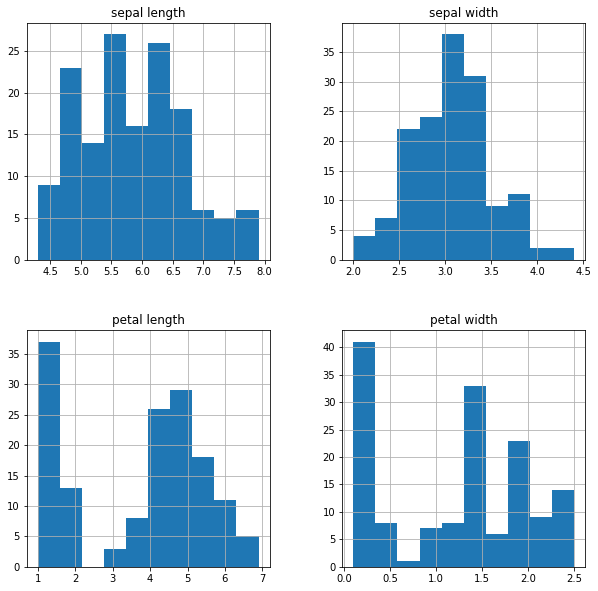

In [6]:
df.hist(figsize=(10,10))
plt.show()

In [7]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
df.dtypes

sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
class            object
dtype: object

In [9]:
df['class'] = df['class'].astype('category')
df['class'] = df['class'].cat.codes

In [10]:
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [11]:
features = df.columns.tolist()[:-1]

In [12]:
X = df[features]
y = df['class']

In [13]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [14]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int8

### Split the data into training and testing dataset

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)

### Feature pairs to be used while plotting decision boundary

In [16]:
feature_pairs = [['sepal length', 'sepal width'],
                 ['sepal length', 'petal length'],
                 ['sepal length', 'petal width'],
                 ['sepal width', 'petal length'],
                 ['sepal width', 'petal width'],
                 ['petal width', 'petal length']]

## Training the model and plotting the decision boundary

### Case-1

In [17]:
model = GaussianBayesClassifier(case=1)
model.train(train_X, train_y)
model.test(test_X, test_y)

True Values: [2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0]
Predictions: [2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 0]
Accuracy: 0.9111111111111111


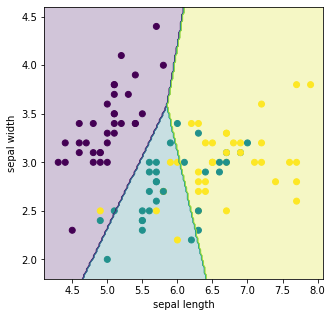

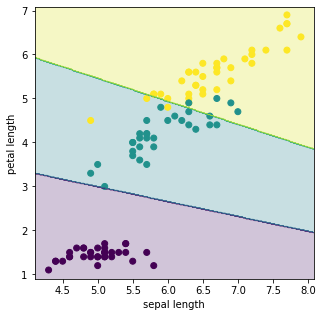

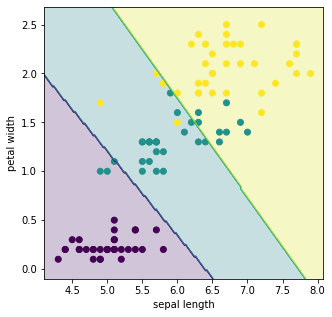

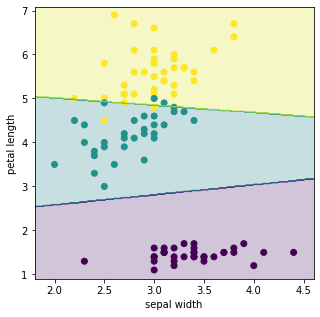

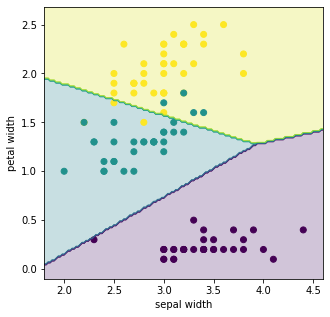

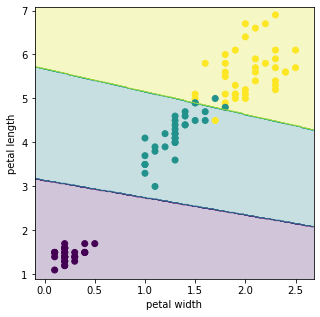

In [18]:
for pair in  feature_pairs:
    model.plot_decision_boundary(train_X, train_y, pair[0], pair[1])

### Case-2

In [19]:
model = GaussianBayesClassifier(case=2)
model.train(train_X, train_y)
model.test(test_X, test_y)

True Values: [2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0]
Predictions: [2, 1, 0, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 2, 0, 2, 0, 0]
Accuracy: 0.8222222222222222


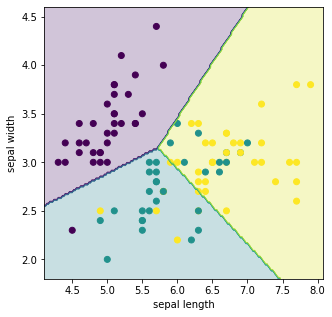

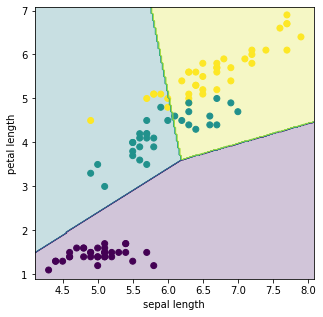

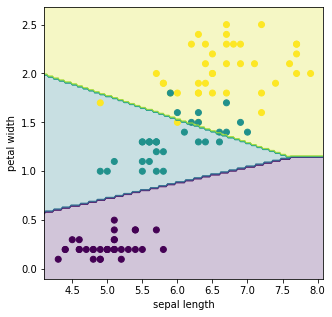

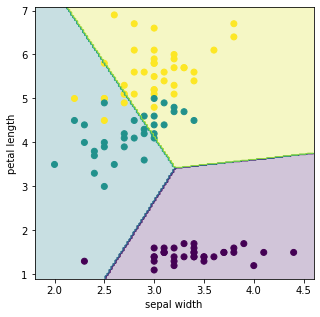

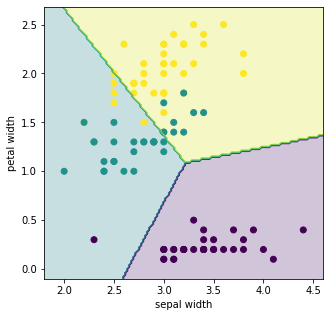

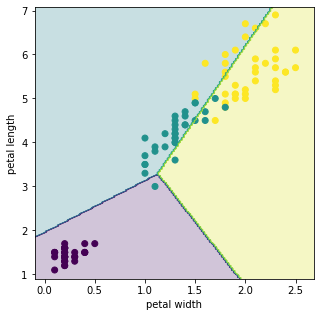

In [20]:
for pair in  feature_pairs:
    model.plot_decision_boundary(train_X, train_y, pair[0], pair[1])

### Case-3

In [21]:
model = GaussianBayesClassifier(case=3)
model.train(train_X, train_y)
model.test(test_X, test_y)

True Values: [2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0]
Predictions: [2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 0]
Accuracy: 0.9777777777777777


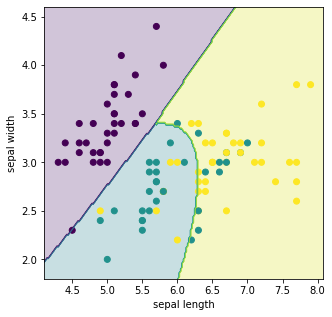

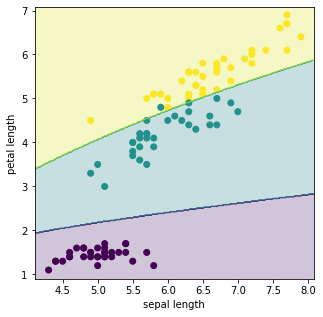

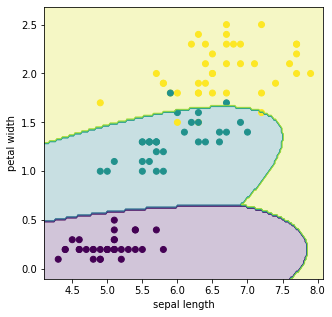

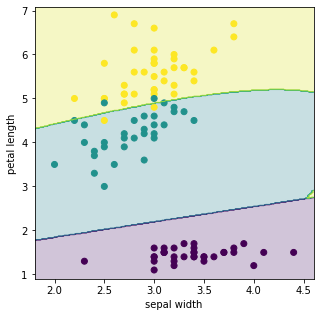

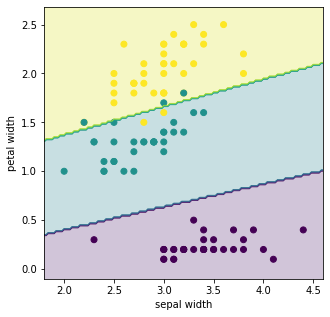

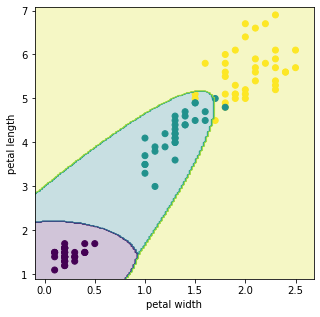

In [22]:
for pair in  feature_pairs:
    model.plot_decision_boundary(train_X, train_y, pair[0], pair[1])

## 5 fold cross validation on the training dataset

In [23]:
def cross_validation(X, y, case):
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    model = GaussianBayesClassifier(case=case)

    accuracy_scores = []
    for train_index , test_index in kf.split(X):
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        train_X, test_X = X.loc[train_index], X.loc[test_index]
        train_y, test_y = y[train_index], y[test_index]

        model.train(train_X, train_y)
        accuracy_scores.append(model.accuracy(test_X , test_y))
    
    print(f'For Case-{case}:')
    print('Accuracy Scores:', accuracy_scores)
    accuracy_scores = np.array(accuracy_scores)
    print('Mean Accuracy Score:', accuracy_scores.mean())
    print()

## Reporting the accuracies on each validation set

In [24]:
cases = [1, 2, 3]
for each in cases:
    cross_validation(X, y, case=each)

For Case-1:
Accuracy Scores: [0.9, 0.8, 0.9666666666666667, 0.9333333333333333, 0.9666666666666667]
Mean Accuracy Score: 0.9133333333333334

For Case-2:
Accuracy Scores: [0.8666666666666667, 0.7333333333333333, 0.9666666666666667, 0.9, 0.8666666666666667]
Mean Accuracy Score: 0.8666666666666668

For Case-3:
Accuracy Scores: [1.0, 0.9333333333333333, 0.9666666666666667, 1.0, 0.9333333333333333]
Mean Accuracy Score: 0.9666666666666666



## Creating synthetic dataset from the circular distribution

In [25]:
PI = math.pi

In [26]:
def distance_from_origin(x, y):
    point1 = np.array((x, y))
    point2 = np.array((0, 0))
    return np.linalg.norm(point1 - point2)

In [27]:
xP = []
yP = []
distances = []

for each in range(200):
    distance = random.uniform(0, 5)
    angle = random.uniform(0, 2*PI)
    x = distance*math.cos(angle)
    y = distance*math.sin(angle)
    xP.append(x)
    yP.append(y)
    distances.append(distance_from_origin(x,y))
    
df = pd.DataFrame({'x': xP, 'y': yP, 'distances': distances})
df['class'] = 2
df['class'][df['distances'] <= 3] = 1
df.drop('distances', axis=1)

,x,y,class
0,3.621051,0.806352,2
1,0.963800,-2.447267,1
2,0.302375,-2.495407,1
3,0.375999,4.165656,2
4,-0.267289,-0.775873,1
...,...,...,...
195,-1.205312,1.875413,1
196,1.694516,-0.789890,1
197,0.435830,0.284063,1
198,-1.832611,1.949728,1


In [28]:
X = df[['x', 'y']]
y = df['class']

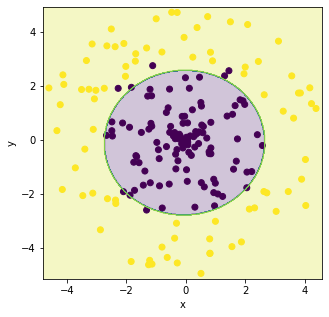

In [29]:
clf = GaussianBayesClassifier(case=3)
clf.train(X, y)
clf.plot_decision_boundary(X, y, 'x', 'y')

---
# Question-2
---

### Finding covariance matrix of sample $X$.

In [30]:
given_cov_mat = np.array([[3/2,1/2],[1/2,3/2]])
given_mean_vec = np.array([0, 0])

In [31]:
x, y = np.random.multivariate_normal(given_mean_vec, given_cov_mat, size=500).T

Here, Sample $X$ = [x, y]

In [32]:
def covariance(x, y):
    n = len(x)
    xmean = np.mean(x)
    ymean = np.mean(y)
    return np.sum(np.multiply((x-xmean),(y-ymean)))/(n-1)

In [33]:
def covariance_matrix(x,y):
    return np.array([[covariance(x,x), covariance(x,y)], [covariance(y,x), covariance(y,y)]])

In [34]:
cov_mat = covariance_matrix(x,y)
cov_mat

array([[1.46394374, 0.37819297],
       [0.37819297, 1.40278023]])

 ### Finding eigen vectors and eigen values of the covariance matrix and plotting it superimposed on the datapoints $X$.

In [35]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

In [36]:
eigvec = np.real(eigenvectors)

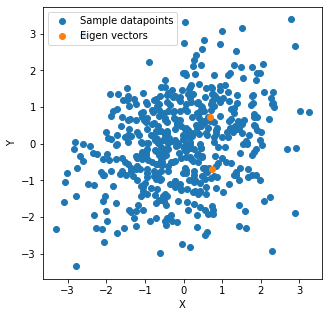

In [37]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Sample datapoints')
plt.scatter(eigvec.T[0], eigvec.T[1], label='Eigen vectors')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Performing transformation $Y = Σ_S^{(−1/2)}X$ on datapoints $X$.

In [38]:
Y = scipy.linalg.fractional_matrix_power(cov_mat, -0.5) @ np.array([x,y])

In [39]:
cov_mat_Y = covariance_matrix(Y[0], Y[1])

In [40]:
cov_mat_Y

array([[ 1.00000000e+00, -3.55983335e-17],
       [-3.55983335e-17,  1.00000000e+00]])

Here, we see that the obtained covariance matrix is approximately equal to identity matrix.   
The purpose of the transformation was to simplify the data points so that while calculating discriminant function for normal density, we can use the simplified covariance matrix expression that acts almost as an identity matrix, so we can ease the calculation part.

### Uniformly sampling 10 points on the curve $x^2 + y^2 = 25$.

In [41]:
PI = math.pi

In [42]:
rad36deg = math.radians(36)

In [43]:
P = []
angle = random.uniform(0, 2*PI)
for each in range(10):
    P.append([5*math.cos(angle), 5*math.sin(angle)])
    angle += rad36deg
    angle %= 2*PI
P = np.array(P)

In [44]:
xP = P.T[0]
yP = P.T[1]

In [45]:
color_list = ['darksalmon', 'gold', 'forestgreen', 'darkturquoise', 'mediumpurple', 
              'lawngreen', 'darkslategray', 'hotpink', 'tomato', 'darkorchid']

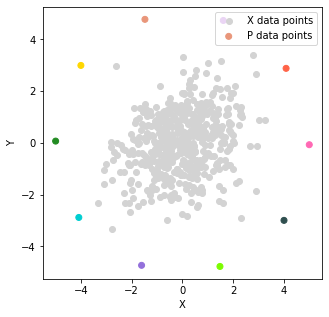

In [46]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x, y, label = "X data points", c='lightgray')
plt.scatter(xP, yP, label = "P data points", c=color_list)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Finding the Euclidean distance of each point from $\mu$ $([0, 0])$

In [47]:
def EuclideanDistance(x1, y1, x2, y2):
    point1 = np.array((x1, y1))
    point2 = np.array((x2, y2))
    return np.linalg.norm(point1 - point2)

In [48]:
ED_array = []
for each in range(10):
    ED_array.append(EuclideanDistance(xP[each], yP[each], 0, 0))

In [49]:
ED_array

[5.0, 4.999999999999999, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

In [50]:
points_array_P = []
for each in range(10):
    points_array_P.append(f'({round(xP[each],2)}, {round(yP[each],2)})')

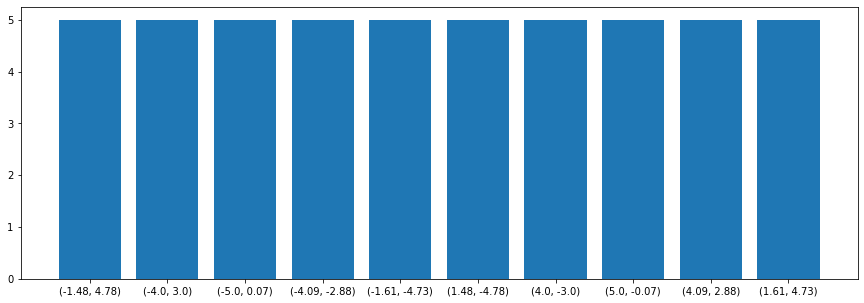

In [51]:
fig = plt.figure(figsize=(15,5))
plt.bar(points_array_P, ED_array)
plt.show()

### Performing transformation $Q = Σ_S^{(−1/2)}X$ on datapoints $P$.

In [52]:
Q = scipy.linalg.fractional_matrix_power(cov_mat, -0.5) @ np.array([xP,yP])

In [53]:
Q

array([[-1.80612571, -3.74475384, -4.25301328, -3.1367662 , -0.82238105,
         1.80612571,  3.74475384,  4.25301328,  3.1367662 ,  0.82238105],
       [ 4.31506012,  3.06055008,  0.63701393, -2.02983988, -3.92136386,
        -4.31506012, -3.06055008, -0.63701393,  2.02983988,  3.92136386]])

### Finding the Euclidean distance of each point in $Q$ from $\mu$ $([0, 0])$

In [54]:
ED_array_Q = []
for each in range(10):
    ED_array_Q.append(EuclideanDistance(Q[0][each], Q[1][each], 0, 0))

In [55]:
ED_array_Q

[4.677802252148402,
 4.836336228049312,
 4.300454478612357,
 3.736248407582418,
 4.006670073818551,
 4.677802252148402,
 4.836336228049312,
 4.300454478612357,
 3.736248407582418,
 4.006670073818551]

In [56]:
points_array_Q = []
for each in range(10):
    points_array_Q.append(f'({round(Q[0][each],2)}, {round(Q[1][each],2)})')

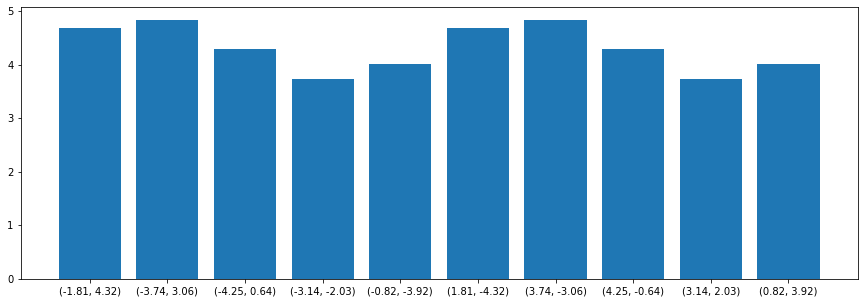

In [57]:
fig = plt.figure(figsize=(15,5))
plt.bar(points_array_Q, ED_array_Q)
plt.show()

In [58]:
dfQ = pd.DataFrame({'x': Q[0], 'y': Q[1]})

### Plotting points in $Q$ along with datapoints in $Y$

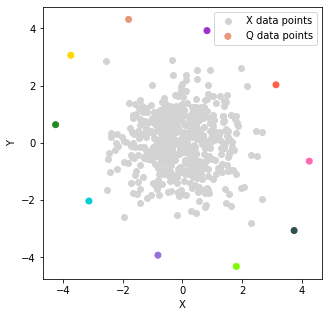

In [59]:
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[0], Y[1], label = "X data points", c='lightgray')
plt.scatter(Q[0], Q[1], label = "Q data points", c=color_list)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()